# **WFLOW: DERIVING INPUT MAPS**

## *PACKAGES*


In [39]:
using  Revise, Rasters, GeoFormatTypes, GeoTIFF, ArchGDAL, Shapefile, NCDatasets, GeoDataFrames
using Colors, ColorSchemes, CairoMakie, DimensionalData
using Geomorphometry

Path_Home = @__DIR__
cd(Path_Home)

include("Julia//Parameters.jl")
include("Julia//GeoRaster.jl")
include("Julia//GeoNetcdf.jl")
include("Julia//PlotParameter.jl")
include("Julia//GeoPlot.jl")

# For new projects if does not exist
   mkpath(joinpath(Path_Root, Path_InputForcing))
   mkpath(joinpath(Path_Root, Path_InputGis))
   mkpath(joinpath(Path_Root, Path_InputLookuptable))
   mkpath(joinpath(Path_Root, Path_NetCDF))
   mkpath(joinpath(Path_Root, Path_OutputJulia))
   mkpath(joinpath(Path_Root, Path_OutputPython))
   mkpath(joinpath(Path_Root, Path_OutputTimeSeriesWflow))
   mkpath(joinpath(Path_Root, Path_OutputWflow))

# Pkg.add(name="ArchGDAL", version="0.10.9")


"d:\\JOE\\MAIN\\MODELS\\WFLOW\\DATA\\TimoleagueCrop\\OutputWflow"

## **=== DEM OPERATIONS ===**

### **== DEM:** *Deriving data from Mosaic  ==*

In [40]:
```
Deriving maps from mosaic
```
if 🎏_Mosaic
    Dem₀ = geoRaster.MOSAIC(;Path_Root_Mosaic, Missing=NaN)

    Path_Output_Mosaic = joinpath(Path_Root, Path_InputGis, Dem_Input_Qgis)

	# Reducing the size of the raw map with the shape file having the same shp file as MOSAIC
	Path_Input_Shp = joinpath(Path_Root, Path_InputGis, Mask_Shp)
	Mask_Shapefile= GeoDataFrames.read(Path_Input_Shp)
	println(Path_Input_Shp)

	Dem₀ = Rasters.mask(Dem₀; with=Mask_Shapefile, missingval=NaN, shape=:polygon, boundary=:touches, progress=true)

	Rasters.write(Path_Output_Mosaic, Dem₀; ext=".tiff", missingval=NaN, force=true, verbose=true)
	println(Path_Output_Mosaic)
end


### == **DEM:** *Resampling and deriving new CRS* ==

In [41]:
"""	https://rafaqz.github.io/Rasters.jl/dev/api#Rasters.resample-Tuple
method: A Symbol or String specifying the method to use for resampling. From the docs for gdalwarp:

**:near:** nearest neighbour resampling (default, fastest algorithm, worst interpolation quality).
:bilinear: bilinear resampling.
:cubic: cubic resampling.
:cubicspline: cubic spline resampling.
:lanczos: Lanczos windowed sinc resampling.
:average: average resampling, computes the weighted average of all non-NODATA contributing pixels. rms root mean square / quadratic mean of all non-NODATA contributing pixels (GDAL >= 3.3)
:mode: mode resampling, selects the value which appears most often of all the sampled points.
:max: maximum resampling, selects the maximum value from all non-NODATA contributing pixels.
:min: minimum resampling, selects the minimum value from all non-NODATA contributing pixels.
:med: median resampling, selects the median value of all non-NODATA contributing pixels.
:q1: first quartile resampling, selects the first quartile value of all non-NODATA contributing pixels.
:q3: third quartile resampling, selects the third quartile value of all non-NODATA contributing pixels.
:sum: compute the weighted sum of all non-NODATA contributing pixels (since GDAL 3.1)"""


# Reading data
	if !(🎏_Mosaic)
		Path_InputGis_Dem = joinpath(Path_Root, Path_InputGis, Dem_Input_Qgis)
		Dem₀     = Rasters.Raster(Path_InputGis_Dem)
		Dem₀     = Rasters.replace_missing(Dem₀, missingval=NaN)
	end

   # Resample Dem in 2 steps
      Param_Crs_GeoFormat = GeoFormatTypes.convert(WellKnownText, EPSG(Param_Crs))

    #   Dem_Resample₀ = Rasters.resample(Dem_Resample₀; res=ΔX₁, method=ResampleMethod₁, crs=Param_Crs_GeoFormat)
      Dem_Resample  = Rasters.resample(Dem₀; res=ΔX₂, method=ResampleMethod₂, crs=Param_Crs_GeoFormat)

# Getting the metadata
	Metadatas = geoRaster.RASTER_METADATA(Dem_Resample; Verbose=true)


Param_Crs = 29902
ΔX = 20.0
ΔY = -20.0
N_Width  = 21055
N_Height = 28024
Coord_X_Left = -10566.616338923981, Coord_X_Right = 410513.383661076
Coord_Y_Top = 532331.122395666, Coord_Y_Bottom = -28128.877604334033


Main.geoRaster.METADATA(21055, 28024, 20, -20, -10566.616338923981, 410513.383661076, 532331.122395666, -28128.877604334033, 29902, WellKnownText{GeoFormatTypes.CRS}(GeoFormatTypes.CRS(), "PROJCS[\"TM65 / Irish Grid\",GEOGCS[\"TM65\",DATUM[\"TM65\",SPHEROID[\"Airy Modified 1849\",6377340.189,299.3249646,AUTHORITY[\"EPSG\",\"7002\"]],AUTHORITY[\"EPSG\",\"6299\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4299\"]],PROJECTION[\"Transverse_Mercator\"],PARAMETER[\"latitude_of_origin\",53.5],PARAMETER[\"central_meridian\",-8],PARAMETER[\"scale_factor\",1.000035],PARAMETER[\"false_easting\",200000],PARAMETER[\"false_northing\",250000],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Easting\",EAST],AXIS[\"Northing\",NORTH],AUTHORITY[\"EPSG\",\"29902\"]]"))

### == **DEM:** *Longitute and Latitude* ==

In [42]:
Longitude, Latitude = Rasters.X(Metadatas.Coord_X_Left: Metadatas.ΔX: Metadatas.Coord_X_Right, crs=Metadatas.Crs_GeoFormat), Rasters.Y(Metadatas.Coord_Y_Top: Metadatas.ΔY: Metadatas.Coord_Y_Bottom, crs=Metadatas.Crs_GeoFormat)

@assert(Metadatas.N_Width  == length(Longitude))
@assert(Metadatas.N_Height == length(Latitude))


### == **DEM:** *Deriving a coastal boundary* ==

In [43]:
if 🎏_Coastline && 🎏_Mosaic
	include("Julia//GeoRaster.jl")

	Coastline_Bool, Dem_Resample = geoRaster.DEM_DERIVE_COASTLINES(;Dem=Dem_Resample,  Longitude, Latitude, Crs=Metadatas.Crs_GeoFormat, Missing=NaN, DemMin=5.0)

	# Writting the output
	Path_OutputJulia_Coastline = joinpath(Path_Root, Path_OutputJulia, "Coastline.tiff")
	Rasters.write(Path_OutputJulia_Coastline, Coastline_Bool; ext=".tiff", missingval= NaN, force=true, verbose=true)

    if 🎏_Plots
	    using GLMakie
	    GLMakie.activate!()

	    geoPlot.HEATMAP(;🎏_Colorbar=true, Input=Coastline_Bool, Title="Digital Elevation Model", Label="Altitude [m]", colormap=:greys)
    end
end


### == **DEM:** *Reduce size of map by removing NaN* ==

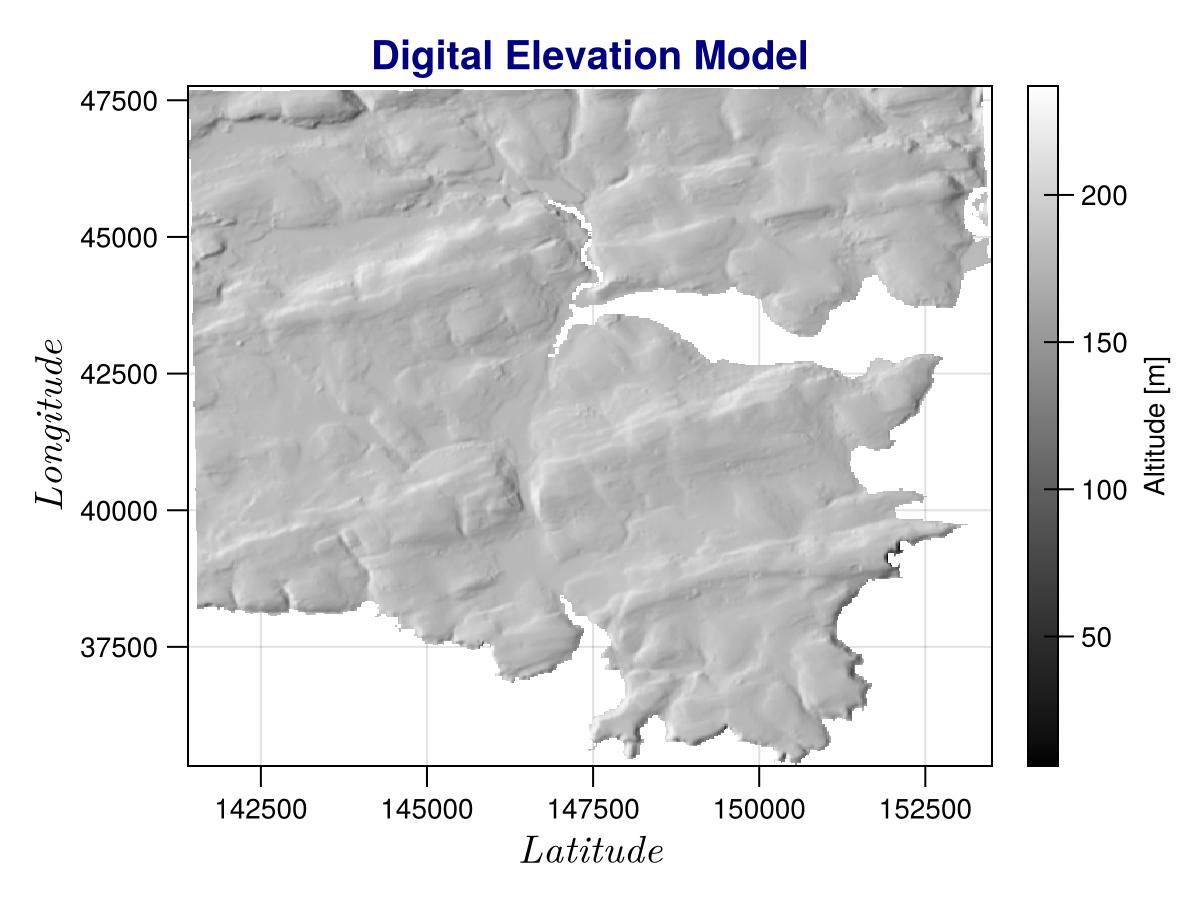

Param_Crs = 29902
ΔX = 20.0
ΔY = -20.0
N_Width  = 605
N_Height = 622
Coord_X_Left = 141413.38366107602, Coord_X_Right = 153493.38366107602
Coord_Y_Top = 47751.12239566597, Coord_Y_Bottom = 35331.12239566597


In [44]:
Dem_Resample = Rasters.trim(Dem_Resample)
Metadatas    = geoRaster.RASTER_METADATA(Dem_Resample; Verbose=true)

Longitude, Latitude = Rasters.X(Metadatas.Coord_X_Left: Metadatas.ΔX: Metadatas.Coord_X_Right, crs=Metadatas.Crs_GeoFormat), Rasters.Y(Metadatas.Coord_Y_Top: Metadatas.ΔY: Metadatas.Coord_Y_Bottom, crs=Metadatas.Crs_GeoFormat)

# Dem_Resample = DimensionalData.shiftlocus(Rasters.Center(), Dem_Resample)

if 🎏_Plots
	using GLMakie
	GLMakie.activate!()

	geoPlot.HEATMAP(;🎏_Colorbar=true, Input= Geomorphometry.multihillshade(Dem_Resample), Title="Digital Elevation Model", Label="Altitude [m]", colormap=:greys)
end


## == **WRITTING OUTPUTS** ==

In [45]:
# Writting the output
	Path_OutputJulia_Dem = joinpath(Path_Root, Path_OutputJulia, Dem_Julia)
    println(Path_OutputJulia_Dem)
	Rasters.write(Path_OutputJulia_Dem, Dem_Resample; ext=".tiff", missingval= NaN, force=true, verbose=true)


d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\OutputJulia\Ireland_DEM_Croped.tiff


"d:\\JOE\\MAIN\\MODELS\\WFLOW\\DATA\\TimoleagueCrop\\OutputJulia\\Ireland_DEM_Croped.tiff"

## ====== **PLEASE RUN PYTHON CODE** =======

++===========================================++


# === **DEM:** *Reading the corrected DEM from python & cleaning data* ===

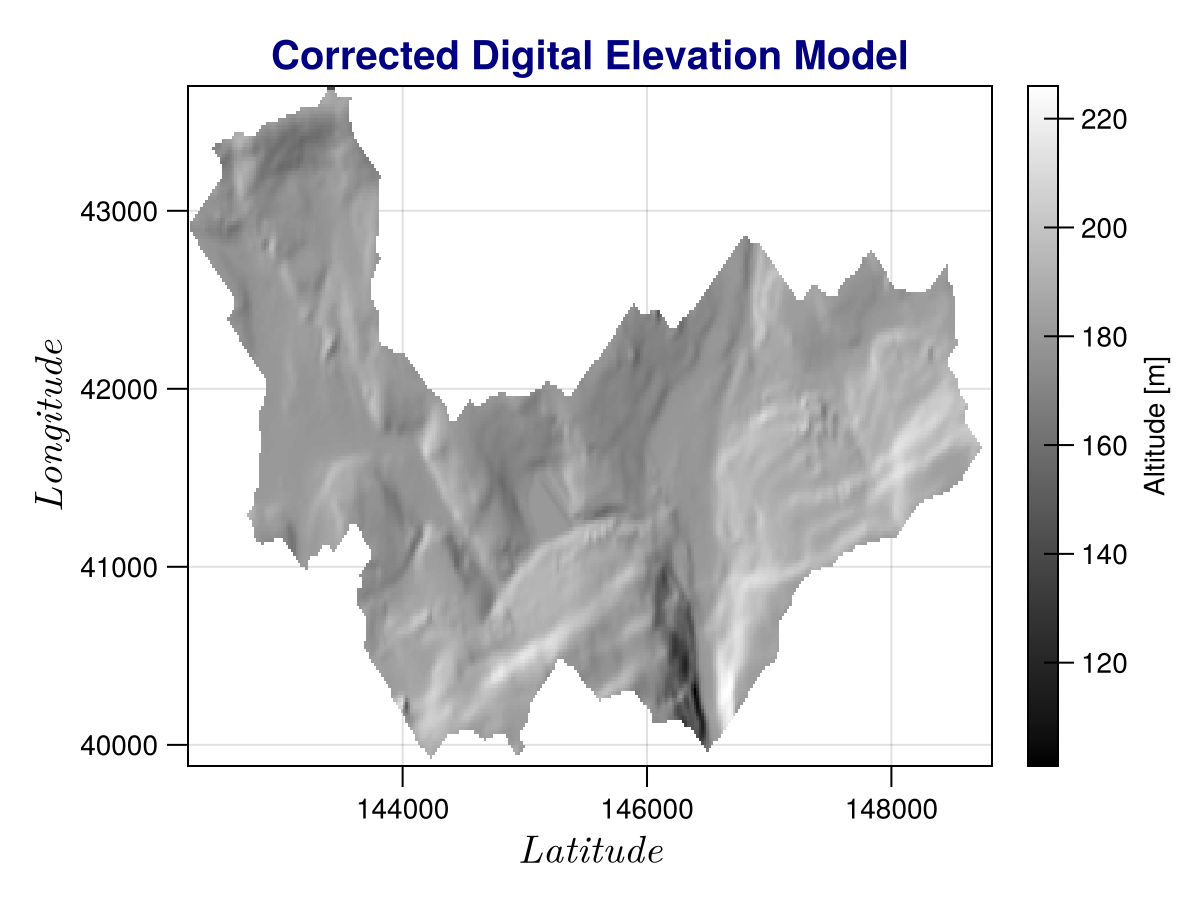

Param_Crs = 29902
ΔX = 20.0
ΔY = -20.0
N_Width  = 329
N_Height = 191
Coord_X_Left = 142253.38366107602, Coord_X_Right = 148813.38366107602
Coord_Y_Top = 43691.12239566597, Coord_Y_Bottom = 39891.12239566597


"d:\\JOE\\MAIN\\MODELS\\WFLOW\\DATA\\TimoleagueCrop\\OutputJulia\\Timoleague_DEM_Corrected.tiff"

In [46]:
include("Julia//GeoRaster.jl")

# Reading data
   Path_InputPython_Dem = joinpath(Path_Root, Path_OutputPython, Dem_Input_Python)

   Dem_Resample₀ = Rasters.Raster(Path_InputPython_Dem)
   Dem_Resample  = Rasters.replace_missing(Dem_Resample₀, missingval=NaN)

# Cleaning data
    Dem_Resample = Rasters.trim(Dem_Resample)
    Dem_Resample = DimensionalData.shiftlocus(Rasters.End(), Dem_Resample)

# Getting the metadata
    Metadatas    = geoRaster.RASTER_METADATA(Dem_Resample; Verbose=true)

# Longitude & Latitude
    Longitude, Latitude = Rasters.X(Metadatas.Coord_X_Left: Metadatas.ΔX: Metadatas.Coord_X_Right, crs=Metadatas.Crs_GeoFormat), Rasters.Y(Metadatas.Coord_Y_Top: Metadatas.ΔY: Metadatas.Coord_Y_Bottom, crs=Metadatas.Crs_GeoFormat)


if 🎏_Plots
	geoPlot.HEATMAP(;🎏_Colorbar=true, Input= Geomorphometry.multihillshade(Dem_Resample), Title="Corrected Digital Elevation Model", Label="Altitude [m]", colormap=:greys)
end

# Writting the output
   Path_OutputJulia_Dem_Corrected = joinpath(Path_Root, Path_OutputJulia, Dem_Julia_Corrected)
   Rasters.write(Path_OutputJulia_Dem_Corrected, Dem_Resample; ext=".tiff", missingval= NaN, force=true, verbose=true)


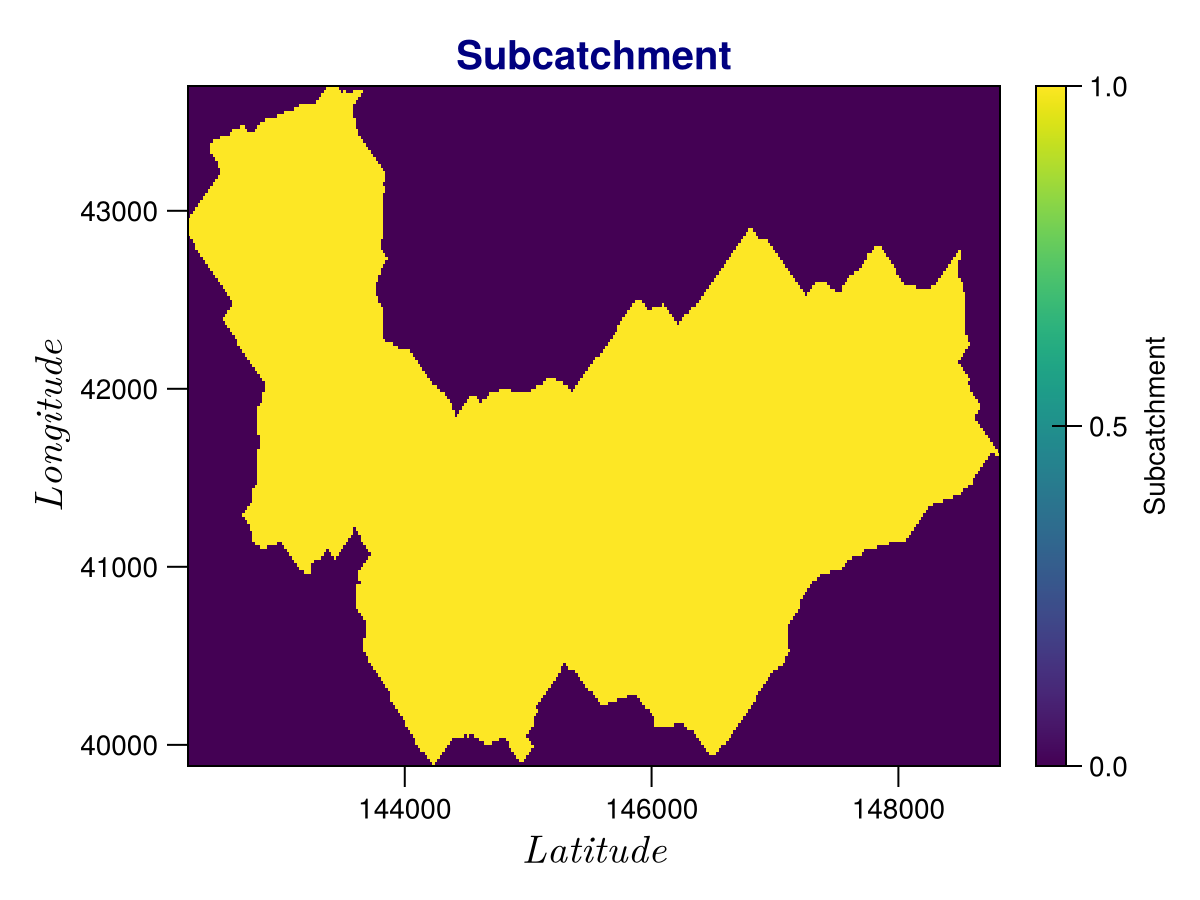

In [47]:
if 🎏_MaskFromDem
    # Computing subcatchments
   Subcatchment = Rasters.Raster((Longitude, Latitude), crs=Metadatas.Crs_GeoFormat)

   for iX=1:Metadatas.N_Width
      for iY=1:Metadatas.N_Height
	    if !isnan(Dem_Resample[iX,iY])
            Subcatchment[iX,iY] = 1
         else
            Subcatchment[iX,iY] = 0
         end
      end # for iY=1:Metadatas.N_Height
   end # for iX=1:Metadatas.N_Width

else
    # Reading Catchement map
    Subcatch_Python    = "Basins.tiff"
    Path_InputPython_Subcatchment = joinpath(Path_Root, Path_OutputPython, Subcatch_Python)
    Subcatchment₀                 = Rasters.Raster(Path_InputPython_Subcatchment)
    Subcatchment₀                 = Rasters.replace_missing(Subcatchment₀, missingval=0)

    # Computing subcatchments
    Subcatchment = Rasters.Raster((Longitude, Latitude), crs=Metadatas.Crs_GeoFormat)

    for iX=1:Metadatas.N_Width
        for iY=1:Metadatas.N_Height
            if Subcatchment₀[iX,iY] ==1
            #  if Subcatchment₀[iX,iY] > 0
                Subcatchment[iX,iY] = 1
            else
                Subcatchment[iX,iY] = 0
            end
        end # for iY=1:Metadatas.N_Height
    end # for iX=1:Metadatas.N_Width

    println(Subcatchment[iiParam_GaugeCoordinate[1],iiParam_GaugeCoordinate[2]])
end # if 🎏_MaskFromDem

if 🎏_Plots
	geoPlot.HEATMAP(;🎏_Colorbar=true, Input=Subcatchment, Title="Subcatchment", Label="Subcatchment")
end


## **CATCHMENT:** *Reading catchment boundary from Python used as a mask*

In [48]:
println(iiParam_GaugeCoordinate[1])
# println(Subcatchment[iiParam_GaugeCoordinate[1],iiParam_GaugeCoordinate[2]])



221


## **DEM:** *Mask to catchment area*

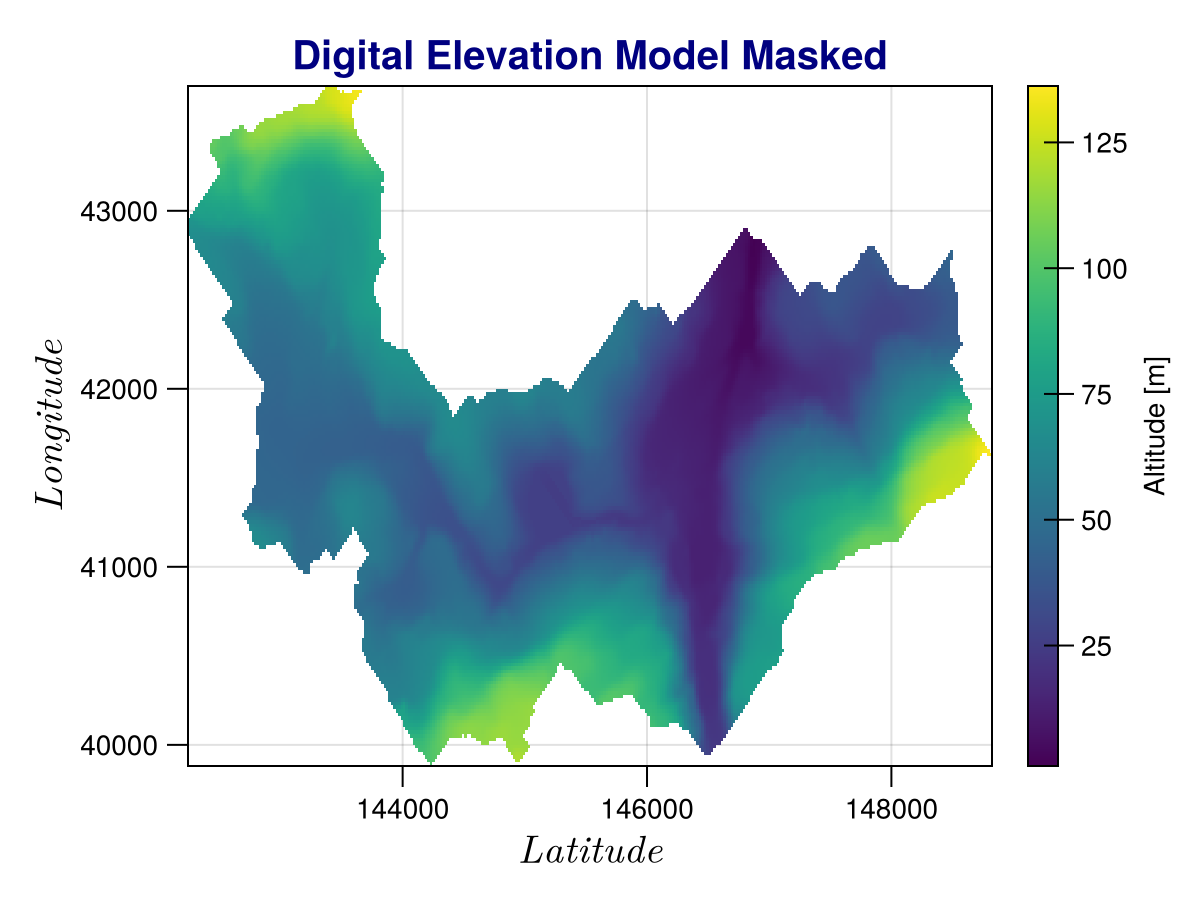

Param_Crs = 29902
ΔX = 20.0
ΔY = -20.0
N_Width  = 329
N_Height = 191
Coord_X_Left = 142253.38366107602, Coord_X_Right = 148813.38366107602
Coord_Y_Top = 43691.12239566597, Coord_Y_Bottom = 39891.12239566597


In [49]:
include("Julia//GeoRaster.jl")

Dem_Resample_Mask = geoRaster.MASK(;Input=Dem_Resample, Mask=Subcatchment, Param_Crs=Metadatas.Crs_GeoFormat, Latitude, Longitude)

🎏_Map₁_Eq_Map₂ = geoRaster.TEST_SAMESIZE(; Map₁=Dem_Resample_Mask, Map₂=Subcatchment, Map₁_Nodata=NaN, Map₂_Nodata=0)

# Writting output
   Path_OutputJulia_DemMask = joinpath(Path_Root, Path_OutputJulia, Dem_Julia_Mask)

   Rasters.write(Path_OutputJulia_DemMask, Dem_Resample_Mask; ext=".tiff", missingval= NaN, force=true, verbose=true)

# Getting the metadata
	Metadatas = geoRaster.RASTER_METADATA(Dem_Resample_Mask; Verbose=true);

if 🎏_Plots
	geoPlot.HEATMAP(;🎏_Colorbar=true, Input= Dem_Resample_Mask, Title="Digital Elevation Model Masked", Label="Altitude [m]")
end


## **DEM:** *flow accumulation*

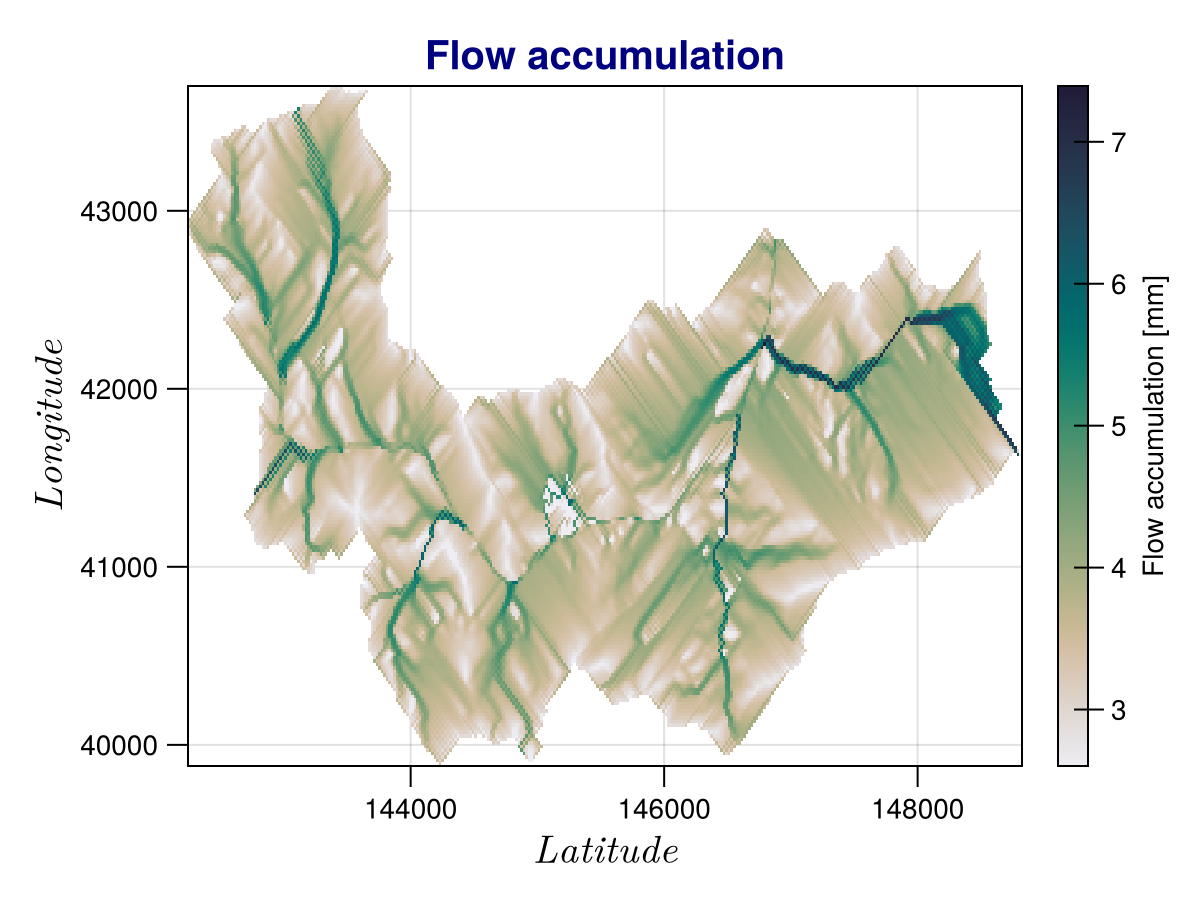

In [50]:
if 🎏_Plots && 🎏_Plot_FlowAccumulation
   # Options: DInf(), D8(), FD8(2)
   Acc, Ldd = Geomorphometry.flowaccumulation(Dem_Resample; method=FD8(4))

   Acc_Mask = geoRaster.MASK(;Param_Crs=Metadatas.Crs_GeoFormat, Input=Acc, Latitude, Longitude, Mask=Subcatchment)

	geoPlot.HEATMAP(;🎏_Colorbar=true, Input= log10.(Acc_Mask), Title="Flow accumulation", Label="Flow accumulation [mm]", colormap=:rain)
end


## **LDD:** *Python Mask to catchment area* 

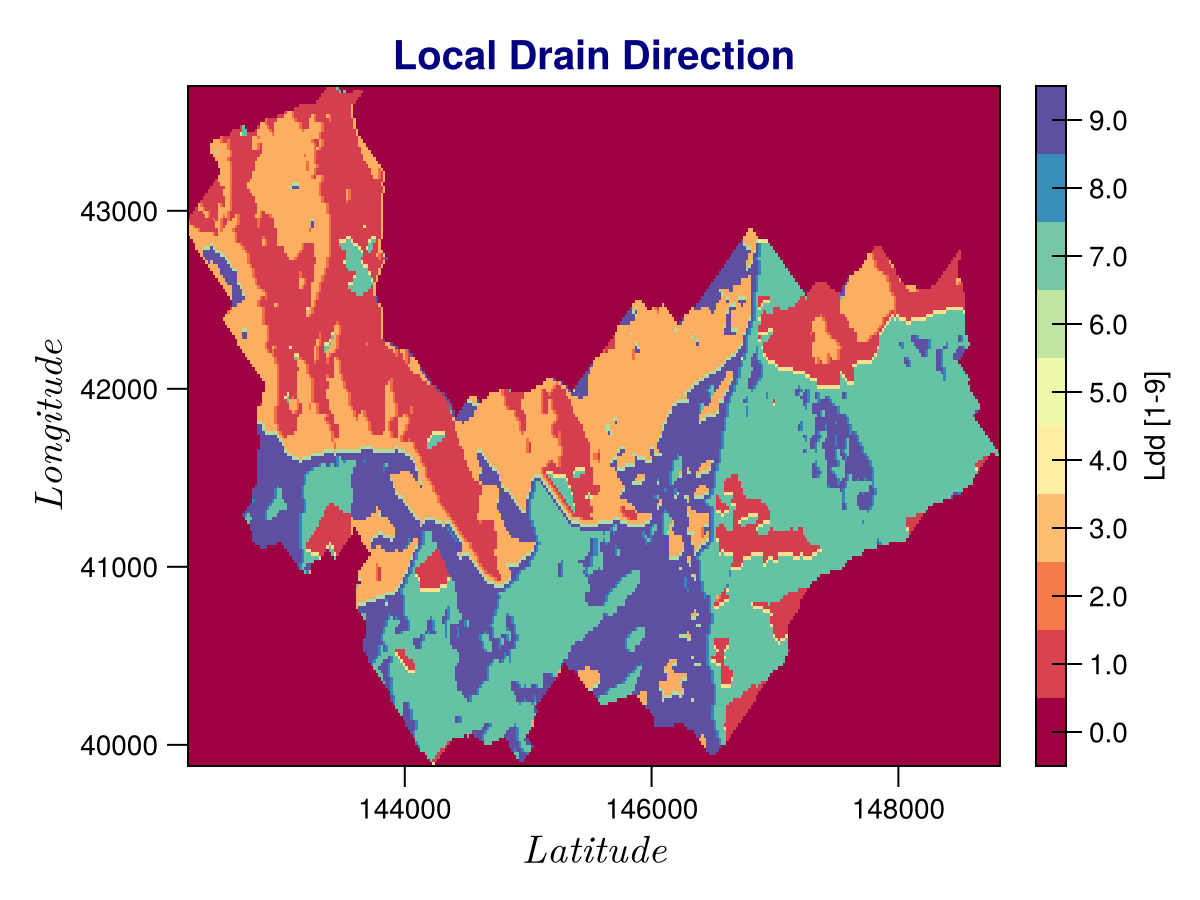

d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\OutputWflow\wflow_ldd.tiff


true

In [51]:
include("Julia//GeoRaster.jl")

Path_InputPython_Ldd = joinpath(Path_Root, Path_OutputPython, Ldd_Python)
Ldd₁                 = Rasters.Raster(Path_InputPython_Ldd)
Ldd₁                 = Rasters.replace_missing(Ldd₁, missingval=0)

# Masking with catchment
   Ldd_Mask = Rasters.resample(Ldd₁; to=Dem_Resample_Mask, missingval=0)

   Ldd_Mask = geoRaster.MASK(;Param_Crs=Metadatas.Crs_GeoFormat, Input=Ldd_Mask, Latitude, Longitude, Mask=Subcatchment, Missing=0)

# Writting output
   Path_OutputWflow_LddMask = joinpath(Path_Root, Path_OutputWflow, Ldd_Wflow)
   Rasters.write(Path_OutputWflow_LddMask, Ldd_Mask; ext=".tiff", force=true, verbose=true)
   println(Path_OutputWflow_LddMask)

if 🎏_Plots
	geoPlot.HEATMAP(;🎏_Colorbar=true, Input=Ldd_Mask, Title="Local Drain Direction", Label="Ldd [1-9]", colormap=Makie.Categorical(:Spectral_11))
end

🎏_Map₁_Eq_Map₂ = geoRaster.TEST_SAMESIZE(; Map₁=Subcatchment, Map₂=Ldd_Mask,  Map₁_Nodata=0, Map₂_Nodata=0)



## == **GAUGE** ==

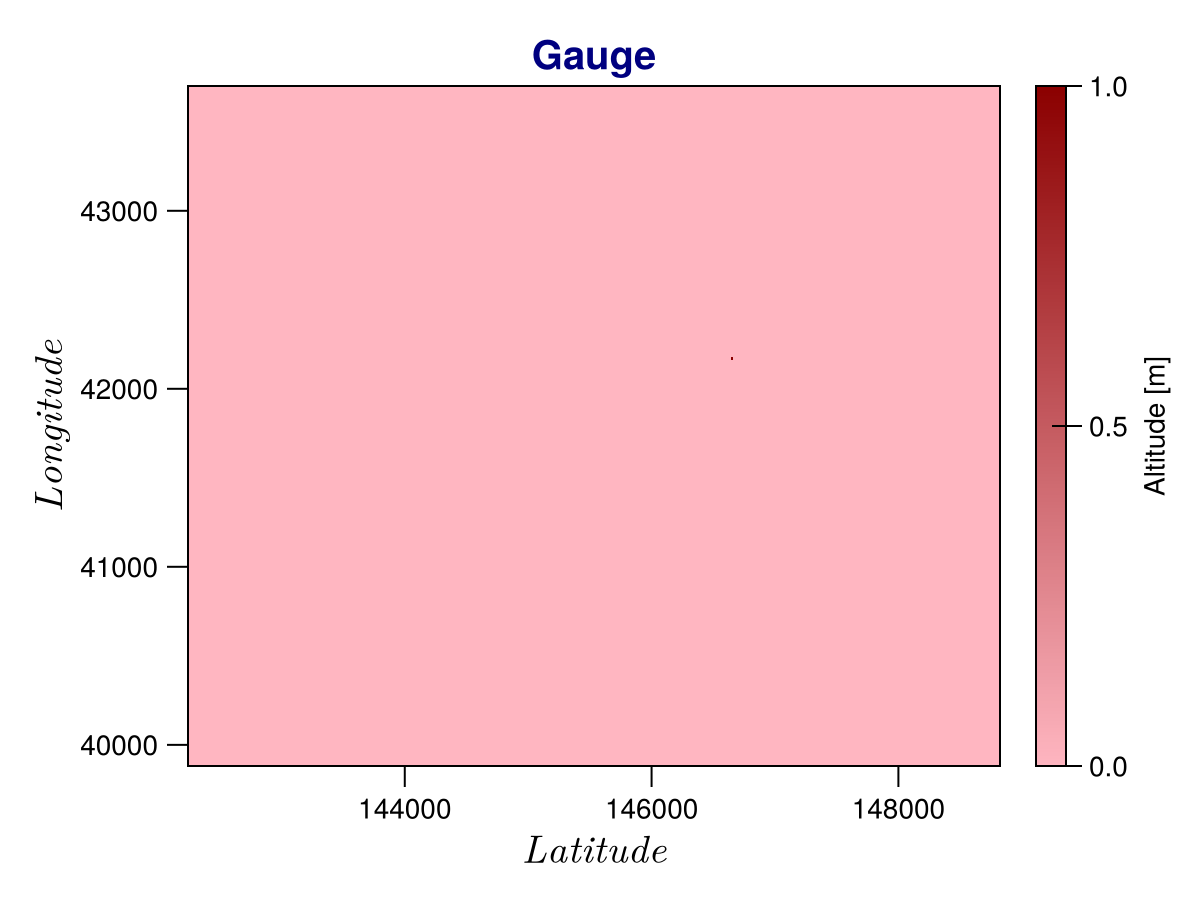

[221, 77]
d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\OutputWflow\wflow_gauges_grdc.tiff


In [52]:
""" Sometimes the Near() method returns the right pixel data, but it’s strange, it “fails” with coordinate points that are pretty at the center of their pixel..
 But also note your Raster does not contain “pixels” that have a center (Intervals on x/y), but Points. So likely your confusion is from treating them as pixels starting from the point at one side"""

Path_OutputGauge = joinpath(Path_Root, Path_OutputWflow, Gauge_Wflow)

Gauge, iiParam_GaugeCoordinate = geoRaster.GAUGE(;🎏_Method_Index = "Rasters", Latitude=Latitude, Longitude=Longitude, Metadatas=Metadatas, Param_GaugeCoordinate, Path_OutputGauge)

if 🎏_Plots
	geoPlot.HEATMAP(;🎏_Colorbar=true, Input= Gauge, Title="Gauge", Label="Altitude [m]", colormap=:reds)
end

println(Path_OutputGauge)


## **RIVER:** *Mask to catchment area*

In [53]:
if 🎏_RiverFromDem
    Path_Input_RiverFromDem  = joinpath(Path_Root, Path_OutputPython, Filename_Dem2Rivers)
    println(Path_Input_RiverFromDem)
    River_Raw     = Rasters.Raster(Path_Input_RiverFromDem)

   River = Rasters.resample(River_Raw; to=Dem_Resample_Mask, missingval=0)
else
    Path_InputGis_River  = joinpath(Path_Root, Path_InputGis, River_Shp)
    println(Path_InputGis_River)

    # Load the shapefile
    River_Raw = Shapefile.Handle(Path_InputGis_River)

    River = Rasters.rasterize(last, River_Raw; res=ΔX₂, fill=1, missingval=0, crs=Metadatas.Crs_GeoFormat, to=Dem_Resample_Mask, shape=:line ,progress=true)
end # if 🎏_RiverFromDem



River_Mask = geoRaster.MASK(;Param_Crs=Metadatas.Crs_GeoFormat, Input=River, Latitude, Longitude, Mask=Subcatchment, Missing=0)

Path_OutputWflow_River = joinpath(Path_Root, Path_OutputWflow, River_Wflow)
Rasters.write(Path_OutputWflow_River, River_Mask; ext=".tiff", force=true, verbose=true)

if 🎏_Plots
   CairoMakie.activate!()
   Fig_6 =  CairoMakie.Figure()
   Axis_6 = CairoMakie.Axis(Fig_6[1, 1], title="Rivers", xlabel= L"$Latitude$", ylabel=L"$Longitude$", ylabelsize=ylabelsize, xlabelsize=xlabelSize, xticksize=xticksize, yticksize=yticksize, titlesize=titlesize,  titlecolor=titlecolor)

   Map_6 = CairoMakie.heatmap!(Axis_6, River_Mask, colormap=Reverse(:lajolla))
#    Map_6 = CairoMakie.heatmap!(Axis_6, Gauge, colormap=:reds)

#    CairoMakie.Colorbar(Fig_6[1, 2], Map_6, label = "Rivers", width = 15, ticksize = 15, tickalign = 0.5)
   CairoMakie.display(Fig_6)
end


d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\OutputPython\Dem2Rivers.tiff


TypeError: TypeError: non-boolean (Missing) used in boolean context

## **PITS**

In [54]:
#   Ldd_Mask[iiParam_GaugeCoordinate[1],iiParam_GaugeCoordinate[2]] = 5

Pits  = Rasters.Raster((Longitude, Latitude), crs=Metadatas.Crs_GeoFormat)

Pits_Count = 0
for iX=1:Metadatas.N_Width
   for iY=1:Metadatas.N_Height
      if Ldd_Mask[iX, iY] == 5
         Pits_Count += 1
         Pits[iX,iY] = Pits_Count
         display("[$iX, $iY]")
    else
        Pits[iX,iY] = NaN
      end
   end # for iY=1:Metadatas.N_Height
end # for iX=1:Metadatas.N_Width

println("	Pits = $Pits_Count")

# Writting output
   PathOutput_Pits = joinpath(Path_Root, Path_OutputJulia, Pits_Julia)
   Rasters.write(PathOutput_Pits, Pits; ext=".tiff", force=true, verbose=true)
   println(PathOutput_Pits)

# if 🎏_Plots
#    CairoMakie.activate!()
#    Fig_2 =  CairoMakie.Figure()
#    Axis_2 = CairoMakie.Axis(Fig_2[1, 1], title="Catchment Boundaries", xlabel= L"Longitude", ylabel=L"Latitude",  ylabelsize=ylabelsize, xlabelsize=xlabelSize, xticksize=xticksize, yticksize=yticksize, titlesize=titlesize,  titlecolor=titlecolor)

#     CairoMakie.heatmap!(Axis_2, Dem_Resample, colormap=:greys)
#     CairoMakie.heatmap!(Axis_2, Pits, colormap=Reverse(:greys))
#     CairoMakie.heatmap!(Axis_2, RiverWidth, colormap=Reverse(:lajolla))
#     # CairoMakie.heatmap!(Axis_2, Geomorphometry.multihillshade(Dem_Resample), colormap=:greys)
#    # Map_2 = CairoMakie.heatmap!(Axis_2, Gauge, colormap=:lajolla)

#    CairoMakie.display(Fig_2)
# end


"[225, 77]"

"[232, 44]"

	Pits = 2
d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\OutputJulia\Timoleague_Pits.tiff


## **SLOPE:** *Reading Slope from Python & Mask*

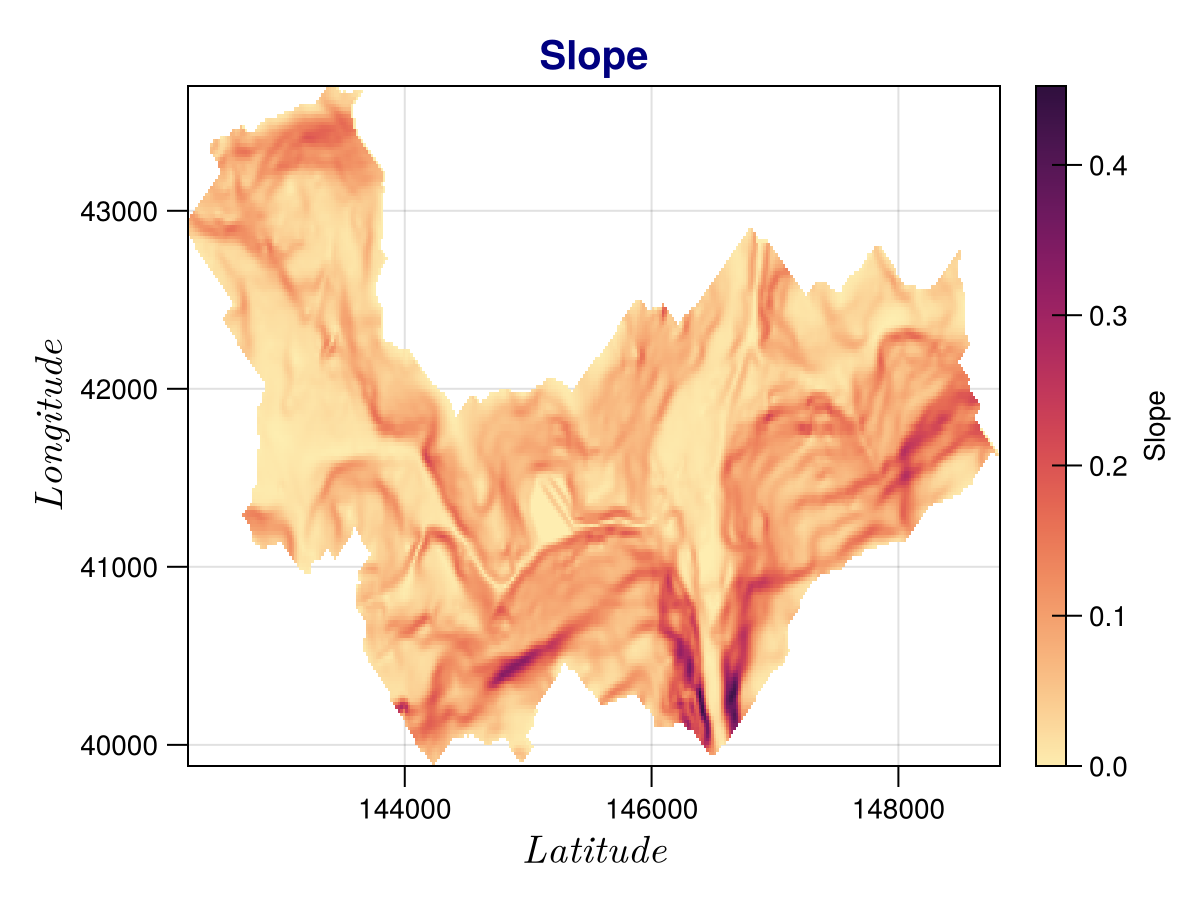

d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\OutputWflow\Slope.tiff


In [55]:
include("Julia//GeoRaster.jl")

Path_InputPython_Slope = joinpath(Path_Root, Path_OutputPython, Slope_Python)

Slope₀ = Rasters.Raster(Path_InputPython_Slope)

Slope = Rasters.replace_missing(Slope₀, missingval=NaN)

Slope = Rasters.resample(Slope₀; to=Dem_Resample_Mask, missingval=0)

Slope_Mask = geoRaster.MASK(;Param_Crs=Metadatas.Crs_GeoFormat, Input=Slope, Latitude, Longitude, Mask=Subcatchment)

# Slope_Mask = Rasters.replace_missing(Slope₀, missingval=NaN)

# Writting the output
Path_OutputWflow_Slope = joinpath(Path_Root, Path_OutputWflow, Slope_Wflow)
Rasters.write(Path_OutputWflow_Slope, Slope_Mask; ext=".tiff", force=true, verbose=true)
println(Path_OutputWflow_Slope)

if 🎏_Plots
	geoPlot.HEATMAP(;🎏_Colorbar=true, Input=Slope_Mask, Title="Slope", Label="Slope", colormap=:matter)
end

# 🎏_Map₁_Eq_Map₂ = geoRaster.TEST_SAMESIZE(; Map₁=Subcatchment, Map₂=Slope_Mask,  Map₁_Nodata=NaN, Map₂_Nodata=NaN)


## **Rivers slope**

In [56]:
include("Julia//GeoRaster.jl")

RiverSlope = geoRaster.MASK(;Param_Crs=Metadatas.Crs_GeoFormat, Input=Slope_Mask, Latitude, Longitude, Mask=River_Mask)

Path_OutputWflow_RiverSlope = joinpath(Path_Root, Path_OutputWflow, RiverSlope_Wflow)

Rasters.write(Path_OutputWflow_RiverSlope, RiverSlope; ext=".tiff", force=true, verbose=true)
println(Path_OutputWflow_RiverSlope)

if 🎏_Plots
   CairoMakie.activate!()
   Fig_12 =  CairoMakie.Figure()
   Axis_12 = CairoMakie.Axis(Fig_12[1, 1], title="River Slope Per Pixel", xlabel= L"$Latitude$", ylabel=L"$Longitude$", ylabelsize=ylabelsize, xlabelsize=xlabelSize, xticksize=xticksize, yticksize=yticksize, titlesize=titlesize, titlecolor=titlecolor)

   # CairoMakie.plot!(Axis_12, River_Mask, colormap=Reverse(:lajolla))
   Map_12 = CairoMakie.heatmap!(Axis_12, RiverSlope, colormap=:viridis)

   Colorbar(Fig_12[1, 2], Map_12, label = "River slope [deg]", width = 15, ticksize = 15, tickalign = 0.5)
   display(Fig_12)
end


UndefVarError: UndefVarError: `River_Mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## **River width**

In [57]:
RiverWidth = Rasters.Raster((Longitude, Latitude), crs=Metadatas.Crs_GeoFormat, mappedcrs=EPSG(Metadatas.Param_Crs))
for iX=1:Metadatas.N_Width
   for iY=1:Metadatas.N_Height
      if River_Mask[iX,iY] == 1
         RiverWidth[iX,iY] = P_RiverWidth
      else
         RiverWidth[iX,iY] = NaN
      end
   end # for iY=1:Metadatas.N_Height
end # for iX=1:Metadatas.N_Width

Path_OutputWflow_RiverWidth = joinpath(Path_Root, Path_OutputWflow, RiverWidth_Wflow)
# Rasters.write(Path_OutputWflow_RiverWidth, RiverWidth; ext=".tiff", force=true, verbose=true)

if 🎏_Plots
   CairoMakie.activate!()
   Fig_9 =  CairoMakie.Figure()
   Axis_9 = CairoMakie.Axis(Fig_9[1, 1], title="River Width", xlabel= L"$Latitude$", ylabel=L"$Longitude$",  ylabelsize=ylabelsize, xlabelsize=xlabelSize, xticksize=xticksize, yticksize=yticksize, titlesize=titlesize,  titlecolor=titlecolor)

   Map_9 = CairoMakie.plot!(Axis_9, RiverWidth, colormap=:lajolla)

   # CairoMakie.Colorbar(Fig_6[1, 2], Map_6, label = "Rivers", width = 15, ticksize = 15, tickalign = 0.5)
   CairoMakie.display(Fig_9)
end


UndefVarError: UndefVarError: `River_Mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## **River depth**

In [58]:
RiverDepth = Rasters.Raster((Longitude, Latitude), crs=Metadatas.Crs_GeoFormat)

for iX=1:Metadatas.N_Width
   for iY=1:Metadatas.N_Height
      if River_Mask[iX,iY] == 1
         RiverDepth[iX,iY] = P_RiverDepth
      else
         RiverDepth[iX,iY] = NaN
      end
   end # for iY=1:Metadatas.N_Height
end # for iX=1:Metadatas.N_Width

Path_OutputWflow_RiverDepth = joinpath(Path_Root, Path_OutputWflow, RiverDepth_Wflow)
println(Path_OutputWflow_RiverDepth)

Rasters.write(Path_OutputWflow_RiverDepth, RiverDepth; ext=".tiff", force=true, verbose=true, crs=Metadatas.Crs_GeoFormat)

if 🎏_Plots
   CairoMakie.activate!()
   Fig_10 =  CairoMakie.Figure()
   Axis_10 = CairoMakie.Axis(Fig_10[1, 1], title="River Depth", xlabel= L"$Latitudeitude$", ylabel=L"$Longitudegitude$",  ylabelsize=ylabelsize, xlabelsize=xlabelSize, xticksize=xticksize, yticksize=yticksize, titlesize=titlesize,  titlecolor=titlecolor)

   Map_10 = CairoMakie.plot!(Axis_10, RiverDepth, colormap=Reverse(:viridis))

   # CairoMakie.Colorbar(Fig_6[1, 2], Map_6, label = "Rivers", width = 15, ticksize = 15, tickalign = 0.5)
   CairoMakie.display(Fig_10)
end


UndefVarError: UndefVarError: `River_Mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## **River length**

In [59]:
Path_InputPython_RiverLength = joinpath(Path_Root, Path_OutputPython, RiverLength_Python)
println(Path_InputPython_RiverLength)

RiverLength₀ = Rasters.Raster(Path_InputPython_RiverLength)
RiverLength₁ = Rasters.resample(RiverLength₀; to=Dem_Resample_Mask, missingval=0)


RiverLength₁ = Rasters.replace_missing(RiverLength₁, missingval=NaN)
RiverLength_Mask = geoRaster.MASK(;Param_Crs=Metadatas.Crs_GeoFormat, Input=RiverLength₁, Latitude, Longitude, Mask=River_Mask)

Path_OutputWflow_RiverLength = joinpath(Path_Root, Path_OutputWflow, RiverLength_Wflow)
Rasters.write(Path_OutputWflow_RiverLength, RiverLength_Mask; ext=".tiff", force=true, verbose=true)
println(Path_OutputWflow_RiverLength)

if 🎏_Plots
   CairoMakie.activate!()
   Fig_12 =  CairoMakie.Figure()
   Axis_12 = CairoMakie.Axis(Fig_12[1, 1], title="River Length Per Pixel", xlabel= L"$Latitude$", ylabel=L"$Longitudegitude$",  ylabelsize=ylabelsize, xlabelsize=xlabelSize, xticksize=xticksize, yticksize=yticksize, titlesize=titlesize, titlecolor=titlecolor)

   Map_12 = CairoMakie.heatmap!(Axis_12, RiverLength_Mask, colormap=:viridis)

   Colorbar(Fig_12[1, 2], Map_12, label = "River length [m]", width = 15, ticksize = 15, tickalign = 0.5)
   display(Fig_12)
end


d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\OutputPython\RiverLength.tiff


UndefVarError: UndefVarError: `River_Mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## **Impermeable layers:**

In [60]:
if 🎏_ImpermeableMap
   Path_InputGis_Roads = joinpath(Path_Root, Path_InputGis, Roads_Shp)
   println(Path_InputGis_Roads)

   Road_Shapefile= GeoDataFrames.read(Path_InputGis_Roads)

   Impermeable = Rasters.rasterize(last, Road_Shapefile;  fill=1, res=Metadatas.ΔX, to=Dem_Resample_Mask, missingval=NaN, shape=:polygon, crs=Param_Crs_GeoFormat, boundary=:touches , progress=true, verbose=true)

   Impermeable_Mask = geoRaster.MASK(;Param_Crs=Metadatas.Param_Crs_GeoFormat, Input=Impermeable, Latitude, Longitude, Mask=Subcatchment)

   Path_OutputWflow_Impermeable = joinpath(Path_Root, Path_OutputWflow, Impermable_Wflow)

   Rasters.write(Path_OutputWflow_Impermeable, Impermeable_Mask; ext=".tiff", force=true, verbose=true)

   geoPlot.HEATMAP(;Title="Roads", Label="Road", Input=Impermeable_Mask, 🎏_Colorbar=false)
else
   Impermeable_Mask = []
end


Any[]

# **SOIL MAPS**

In [61]:
if 🎏_SoilMap
   Path_InputSoils = joinpath(Path_Root, Path_InputGis, SoilMap_Raster)
   println(Path_InputSoils)

   SoilMapₒ = Rasters.Raster(Path_InputSoils)

   SoilMap₁ = Rasters.resample(SoilMapₒ; to=Dem_Resample_Mask, missingval=NaN)

   SoilMap = geoRaster.MASK(;Param_Crs=Metadatas.Crs_GeoFormat, Input=SoilMap₁, Latitude, Longitude, Mask=Subcatchment)

   if 🎏_Plots
      geoPlot.HEATMAP(;🎏_Colorbar=true, Input=SoilMap, Label="Infiltration index [-]", Title ="Soil Maps" )
   end
end


d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\InputGis\SoilMap_Raster.tif


ArgumentError: ArgumentError: file "d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\InputGis\SoilMap_Raster.tif" not found

# **LOOKUP TABLES**


## *Lookup hydro parameters*

In [62]:
if 🎏_SoilMap
   include("Julia//geoRaster.jl")
   include("Julia//Parameters.jl")

   Soil_Header, Soil_Maps = geoRaster.LOOKUPTABLE_2_MAPS(;🎏_Plots, Param_Crs=Metadatas.Crs_GeoFormat, Dem_Resample_Mask, Latitude, Longitude, LookupTable=Lookup_Hydro, Map_Shp=SoilMap_Shp, Map_Value=:Drainage_C, Metadatas, Path_InputGis, Path_Root, Path_Root_LookupTable, Subcatchment, TitleMap="Soil Map", ΔX=ΔX₂)
else
   Soil_Header = Soil_Maps = []
end # if 🎏_SoilMap


d:\JOE\MAIN\MODELS\WFLOW\WflowDataJoe\WflowRaster.jl\DATA//Lookuptable\LookupTable_Hydro.csv
InlineStrings.String15["Well", "Poorly", "Imperfectly", "Moderately", "missing"]
d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\InputGis\SoilMap.shp


ArgumentError: ArgumentError: File not found: d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\InputGis\SoilMap.dbf

## *Lookup vegetation parameters*

In [63]:
   include("Julia//geoRaster.jl")
   include("Julia//Parameters.jl")
if 🎏_VegetationMap
   Vegetation_Header, Vegetation_Maps = geoRaster.LOOKUPTABLE_2_MAPS(;🎏_Plots, Colormap=:plasma, Param_Crs=Metadatas.Crs_GeoFormat, Dem_Resample_Mask, Latitude, Longitude, LookupTable=Lookup_Vegetation, Map_Shp=VegetationMap_Shp, Map_Value=:CROP_DESC, Metadatas, Path_InputGis, Path_Root, Path_Root_LookupTable, Subcatchment, TitleMap="Vegetation Map", ΔX=ΔX₂)
else
   Vegetation_Header = Vegetation_Maps = []

end # if 🎏_VegetationMap


d:\JOE\MAIN\MODELS\WFLOW\WflowDataJoe\WflowRaster.jl\DATA//Lookuptable\LookupTable_Veg.csv
InlineStrings.String31["Permanent Pasture", "Grass", "Barley", "Spring Wheat", "Maize", "Other", "Beet", "Fodder Beet", "Building", "Arable Silage", "Sugar Beet", "Triticale", "Wheat", "Spring Barley", "Potatoes", "Forestry", "Green Cover", "Setaside", "Bog", "Scrub", "Linnet Habitat", "Swede", "Non-Food", "Fallow", "Farmyard", "Oats", "Winter Barley", "Turnips", "Beans", "Winter Oats", "Oilseed", "Kale", "Peas", "Habitat", "Winter Wheat", "REPS 3 Habitat", "Forage", "Invalid Crop"]
d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\InputGis\Landuse.shp


ArgumentError: ArgumentError: File not found: d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\InputGis\Landuse.dbf

# **NETCDF**

## ***Static maps***

In [64]:
include("Julia//GeoNetcdf.jl")

if 🎏_NetCDF
   NetCDF, Path_NetCDF_Full = geoNetcdf.TIFF_2_NETCDF(Gauge, Impermable_Wflow, Impermeable_Mask, Latitude, Ldd_Mask, Longitude, Metadatas, River_Mask, River_Wflow, RiverDepth, RiverDepth_Wflow, RiverLength_Mask, RiverSlope, RiverSlope_Wflow, RiverWidth, RiverWidth_Wflow, Slope_Mask, Soil_Header, Soil_Maps, Subcatch_Wflow, Subcatchment, Vegetation_Header, Vegetation_Maps)
   end

Path_Copy =  joinpath(Path_Root, Path_NetCDF, NetCDF_Instates)
Path_Paste  = joinpath(Path_Root_NetCDF, NetCDF_Instates)
Base.Filesystem.cp(Path_Copy, Path_Paste, force=true)


UndefVarError: UndefVarError: `River_Mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [65]:
Output_NCDatasets = NCDatasets.NCDataset(Path_NetCDF_Full)
close(Output_NCDatasets)


UndefVarError: UndefVarError: `Path_NetCDF_Full` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [66]:
# NCDatasets.close(Output_NCDatasets)

Path_Copy =  joinpath(Path_Root, Path_NetCDF, NetCDF_Instates)
Path_Paste  = joinpath(Path_Root_NetCDF, NetCDF_Instates)
Base.Filesystem.cp(Path_Copy, Path_Paste, force=true)


Base.IOError: IOError: open("d:\\JOE\\MAIN\\MODELS\\WFLOW\\DATA\\TimoleagueCrop\\OutputNetCDF\\staticmaps-Timoleague.nc", 0, 0): no such file or directory (ENOENT)

### ***Plotting NetCDF maps***

In [67]:
if 🎏_Plots && 🎏_Plot_NetCDF
	using NCDatasets

	Path_NetCDF_Full  = joinpath(Path_Root, Path_NetCDF, NetCDF_Instates)
	Output_NCDatasets = NCDatasets.NCDataset(Path_NetCDF_Full)

	Keys = NCDatasets.keys(Output_NCDatasets)

	Keys_Select = []
	for iiKeys ∈ Keys
		Output = Output_NCDatasets[iiKeys]
		Dimensions = length(size(Output))

		if Dimensions == 2
				push!(Keys_Select, String(iiKeys))
		end # Dimensions == 2
	end # for iiKeys ∈ Keys

	Keys_Select = String.(Keys_Select)
	println(Keys_Select)

	for iiKeys ∈ Keys_Select
		println(iiKeys)
		Map₀ = Array(Output_NCDatasets[iiKeys])

		# Clean data
			FillValue = Output_NCDatasets[iiKeys].attrib["_FillValue"]
			Map =  replace(Map₀, FillValue => NaN)

		geoPlot.HEATMAP(;🎏_Colorbar=true, Input=Map, Label="$iiKeys", Title="$iiKeys", Xlabel= L"$iX$", Ylabel=L"$iY$", Yreversed=true, colormap=:hawaii50)
	end
end  # if: 🎏_Plots &&

Output_NCDatasets = nothing


## ***Timeseries NetCDF maps***

In [68]:
if 🎏_Forcing_2_NetCDF
	include("Julia//Parameters.jl")
	include("Julia//GeoRaster.jl")
	include("Julia//GeoNetcdf.jl")
	# include("Julia//PlotParameter.jl")

	NetCDFmeteo, Path_NetCDFmeteo_Output = geoNetcdf.TIMESERIES_2_NETCDF(Latitude, Longitude, Metadatas, Subcatchment)

	if 🎏_Plot_TimeSeries
   	# precip pet temp
   	geoPlot.HEATMAP_TIME(;Path=Path_NetCDFmeteo_Output, NameOutput="temp", Layer=1)
	end
end


Starting Dates = 2010-01-01T00:00:00 
Ending Dates = 2010-03-01T00:00:00 
d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\InputTimeSeries/TimeSeries_Process\forcing.Timoleague.csv


ArgumentError: ArgumentError: "d:\JOE\MAIN\MODELS\WFLOW\DATA\TimoleagueCrop\InputTimeSeries/TimeSeries_Process\forcing.Timoleague.csv" is not a valid file or doesn't exist

In [69]:
if 🎏_Forcing_2_NetCDF
	Path_Copy =  joinpath(Path_Root, Path_NetCDF, NetCDF_Forcing)
	Path_Paste  = joinpath(Path_Root_NetCDF, NetCDF_Forcing)
	Base.Filesystem.cp(Path_Copy, Path_Paste, force=true)
end


Base.IOError: IOError: open("d:\\JOE\\MAIN\\MODELS\\WFLOW\\DATA\\TimoleagueCrop\\OutputNetCDF\\forcing-Timoleague.nc", 0, 0): no such file or directory (ENOENT)

In [70]:

# include(raw"d:\JOE\MAIN\MODELS\WFLOW\WflowDataJoe\WflowRaster.jl\src\GeoRaster.jl")

# Path_InputGis_Gauge  = joinpath(Path_Root, Path_InputGis, Gauge_Shp)
# println(Path_InputGis_Gauge)

# # Load the shapefile
# Gauge_Raw = Shapefile.Handle(Path_InputGis_Gauge)

# Gauge = Rasters.rasterize(last, Gauge_Raw; res=ΔX₂, fill=1, missingval=NaN, crs=Metadatas.Param_Crs_GeoFormat, to=Dem_Resample_Mask, shape=:point ,progress=true)

# for iLongitudeg=1:Metadatas.N_Width
# 	for iLatitude=1:1:Metadatas.N_Height
# 		if Gauge[iLongitudeg, iLatitude] == 1

#          println( "Point:  Nlongitude= $(Metadatas.N_Width) iLongitudegitude= $iLongitudeg Nlatitude= $(Metadatas.N_Height) iLatitudeitude= $iLatitude")

# 		end
# 	end # for iY=1:Metadatas.N_Height
# end # for iX=1:Metadatas.N_Width

# iLatitude, iLongitudeg, Latitudeitude, Longitudegitude, Nlatitude, Nlongitude = geoRaster.LAT_LONG_2_INDEX(;Map=Gauge, Param_GaugeCoordinate)

# Path_OutputJulia_Gauge = joinpath(Path_Root, Path_OutputJulia, Gauge_Julia)
# Rasters.write(Path_OutputJulia_Gauge, Gauge; ext=".tiff", force=true, verbose=true, missingval= NaN)

# if 🎏_Plots
#    using CairoMakie, Colors, ColorSchemes
#    include(raw"d:\JOE\MAIN\MODELS\WFLOW\WflowDataJoe\WflowRaster.jl\src\GeoPlot.jl")

#    CairoMakie.activate!()
#    Fig_6 =  CairoMakie.Figure()
#    Axis_6 = CairoMakie.Axis(Fig_6[1, 1], title="Rivers", xlabel= L"$Latitudeitude$", ylabel=L"$Longitudegitude$",  ylabelsize=ylabelsize, xlabelsize=xlabelSize, xticksize=xticksize, yticksize=yticksize, titlesize=titlesize,  titlecolor=titlecolor)

#    Map_6 =  CairoMakie.heatmap!(Axis_6, Gauge, colormap=:lajolla)

#    # CairoMakie.Colorbar(Fig_6[1, 2], Map_6, label = "Rivers", width = 15, ticksize = 15, tickalign = 0.5)
#    CairoMakie.display(Fig_6)
# end



In [71]:
# Path = raw"D:\JOE\MAIN\MODELS\WFLOW\DATA\Ballycanew\InputGis\Ballycanew_DTM_1M.tif"
# Dem_Resample₀ = Rasters.Raster(Path, missingval=NaN)
# Dem_Resample₁ = Rasters.resample(Dem_Resample₀; res=5.0, method=ResampleMethod₁, crs=Param_Crs_GeoFormat)
# Dem_Resample  = Rasters.resample(Dem_Resample₁; res=10.0, method=ResampleMethod₂, crs=Param_Crs_GeoFormat)

# 	Path_Output = raw"D:\JOE\MAIN\MODELS\WFLOW\DATA\Ballycanew\OutputJulia\FlowAccumulation.tif"
# 	Rasters.write(Path_Output, log10.(Acc); ext=".tiff", missingval= NaN, force=true, verbose=true)


In [72]:
# GAUGES
# Param_GaugeCoordinate_X_Right_Top    = [146709.6323,42159.6226]
# Param_GaugeCoordinate_X_Left_Top     = [146700.2167,42159.7300]
# Param_GaugeCoordinate_X_Right_Bottom = [146709.7495,42150.1972]
# Param_GaugeCoordinate_X_Left_Bottom  = [146700.2801,42150.2118]

# GAUGE(Gauge_Name="Gauge_Wflow_X_Right_Top.tiff", Param_GaugeCoordinate=Param_GaugeCoordinate_X_Right_Top, ΔX=Metadatas.ΔX)

# println(Param_GaugeCoordinate_Center)

# GAUGE(Gauge_Name="Gauge_Wflow_X_Left_Top.tiff", Param_GaugeCoordinate=Param_GaugeCoordinate_X_Left_Top, ΔX=Metadatas.ΔX)

# GAUGE(Gauge_Name="Gauge_Wflow_Center.tiff", Param_GaugeCoordinate=Param_GaugeCoordinate_Center, ΔX=Metadatas.ΔX)

# GAUGE(Gauge_Name="Gauge_Wflow_X_Right_Bottom.tiff", Param_GaugeCoordinate=Param_GaugeCoordinate_X_Right_Bottom, ΔX=Metadatas.ΔX)


# Param_GaugeCoordinate_Center         = [(Param_GaugeCoordinate_X_Left_Top[1] + Param_GaugeCoordinate_X_Right_Bottom[1]) / 2.0 ,  (Param_GaugeCoordinate_X_Left_Top[2] + Param_GaugeCoordinate_X_Right_Bottom[2]) / 2.0 ]


# LOCUS

In [73]:

		# Dem_Resample = Rasters.set(Dem_Resample₀,  X => Rasters.Center)
		# Dem_Resample = Rasters.set(Dem_Resample₀,  Y => Rasters.Center)

		# Dem_Resample₀ = Rasters.set(Dem_Resample₀, X => Rasters.Intervals(Rasters.Start()))
		# Dem_Resample₀ = Rasters.set(Dem_Resample₀, Y => Rasters.Intervals(Rasters.Start()))

		# Dem_Resample₀ = Rasters.set(Dem_Resample₀, X => Rasters.Intervals(Rasters.End()))
		# Dem_Resample₀ = Rasters.set(Dem_Resample₀, Y => Rasters.Intervals(Rasters.End()))
		# https://rafaqz.github.io/Rasters.jl/dev/tutorials/resample#Sinusoidal-Projection-MODIS
		# locus_resampled = DimensionalData.shiftlocus(Center(), ras_epsg)


## == **DEM:** ***pit location*** == 

## **DEM:** *DEM correct boarders*

In [74]:
if 🎏_Fix_Cyclic
	include("Julia//GeoRaster.jl")

	Dem_Resample, Dem_Boarder₀ = geoRaster.DEM_CORRECT_BOARDERS!(; Dem=Dem_Resample,  Latitude, Longitude, Crs=Metadatas.Crs_GeoFormat, iiParam_GaugeCoordinate)

	Dem_Boarder = Rasters.replace_missing(Dem_Boarder₀, missingval=NaN)

	# # Dem_Resample = Rasters.set(Dem_Resample,  Rasters.Center)

	if 🎏_Plots
		geoPlot.HEATMAP(;🎏_Colorbar=true, Input= Dem_Boarder, Title="Boarders", Label="True [m]")
	end

	# Writting the output
		Path_OutputJulia_Dem = joinpath(Path_Root, Path_OutputJulia, "Boarder.tiff")
		Rasters.write(Path_OutputJulia_Dem, Dem_Boarder; ext=".tiff", missingval= NaN, force=true, verbose=true)
end


## == **DEM:** ***pit location*** == 

In [75]:
if 🎏_Fix_Cyclic
	Dem_Coordinate = Dem_Resample[iiParam_GaugeCoordinate[1], iiParam_GaugeCoordinate[2]]
	Dem_Resample[iiParam_GaugeCoordinate[1], iiParam_GaugeCoordinate[2]] = Dem_Coordinate - 100.0
end


In [76]:
if 🎏_Fix_Cyclic
	include("Julia//GeoRaster.jl")

	Dem_Resample, Dem_Boarder₀ = geoRaster.DEM_CORRECT_BOARDERS!(; Dem=Dem_Resample,  Latitude, Longitude, Crs=Metadatas.Crs_GeoFormat, iiParam_GaugeCoordinate)

	Dem_Boarder = Rasters.replace_missing(Dem_Boarder₀, missingval=NaN)

	# # Dem_Resample = Rasters.set(Dem_Resample,  Rasters.Center)

	if 🎏_Plots
		geoPlot.HEATMAP(;🎏_Colorbar=true, Input= Dem_Boarder, Title="Boarders", Label="True [m]")
	end

	# Writting the output
		Path_OutputJulia_Dem = joinpath(Path_Root, Path_OutputJulia, "Boarder.tiff")
		Rasters.write(Path_OutputJulia_Dem, Dem_Boarder; ext=".tiff", missingval= NaN, force=true, verbose=true)
end
